In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy
from util import load_sample,load_acertos, provas, params_inep, item_info_inep

%load_ext autoreload
%autoreload 2

sns.set_context('paper',font_scale=1.2,rc={"figure.figsize": (10,6)})
sns.set_style('darkgrid')

# Calcular as notas pela TRI
No notebook PrepareData tranformamos os microdados e as padrões de resposta dos candidatos num formato conveniente de 0 e 1 para os acertos. Vamos carregar os padrões com a função `load_acertos`. As últimas três colunas são o número de acertos, o número do caderno que o candidato usou e a nota que o INEP deu ao candidato. 

In [3]:
ano = 2023
area = 'MT'
padr = load_acertos(ano,area,5)
display(padr)

,126039,85504,28932,125935,126028,13725,141513,27119,125902,111754,...,27330,16795,141566,125884,84857,125888,125933,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210058064648,1,0,1,1,1,1,1,1,0,0,...,0,0,1,1,0,0,0,23,1212,666.5
210061934543,1,0,0,1,0,0,1,1,0,0,...,0,0,1,0,0,1,1,17,1213,603.8
210061092469,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,6,1212,374.1
210058965637,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,8,1211,451.4
210059313284,1,0,0,1,0,1,1,1,1,0,...,0,0,0,1,1,1,0,24,1213,700.0


Se quiser usar somente o padrão de resposta, tire estas últimas três colunas com o seguinte idioma (truque). Leia assim: iloc escolhe todas as linhas, e todas as colunas até a "última -3". 

In [4]:
padr.iloc[:,:-3]

,126039,85504,28932,125935,126028,13725,141513,27119,125902,111754,...,141567,98278,81946,27330,16795,141566,125884,84857,125888,125933
candidato,,,,,,,,,,,,,,,,,,,,,
210058064648,1,0,1,1,1,1,1,1,0,0,...,1,0,1,0,0,1,1,0,0,0
210061934543,1,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,1
210061092469,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210058965637,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
210059313284,1,0,0,1,0,1,1,1,1,0,...,0,0,1,0,0,0,1,1,1,0


Note que são 43 colunas, indicando que há 2 itens descartados pelo inep. Vamos conferir

In [6]:
params = params_inep(ano,area,dropna=False)
params[params['a_inep'].isna()]

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
86360,NaN,NaN,NaN,1
14887,NaN,NaN,NaN,1


Agora vamos transformar os padrões de resposta em nota, usando a Teoria de Resposta ao Item. 

A TRI propoe um modelo probabilístico para a geração de padrões de respostas como estes mostrado acima. O chamado modelo de três parâmetros logístico para a probabilidade de acertar um determinado item é:

$$ P(x=1|\theta) = c+ \frac{1-c}{1+e^{a(b-\theta )}} $$

onde os parâmetros $a,b$ e $c$ dependem da cada item e $P(x=1|\theta)$ é a probabilidade de acertar o item, dado uma habilidade $\theta$. Veja alguns parâmetros dos itens, segundo as calibrações do INEP:

In [7]:
ano = 2023
area = 'MT'
params = params_inep(ano, area).sample(5) # só 5 dos 45 itens, para ilustrar
params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
31650,3.33563,1.08025,0.20912,1
37441,3.01304,2.67185,0.08455,1
125977,2.04085,1.27709,0.27067,1
117634,3.29744,2.42208,0.14073,1
141570,1.79257,0.86167,0.17314,1


In [8]:
def PL3(theta,a=1,b=0,c=0):
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))

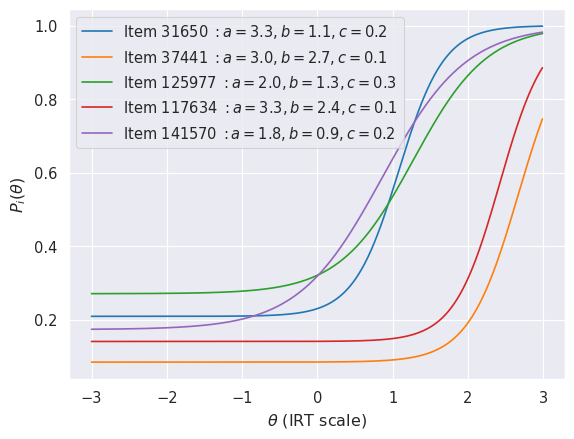

In [9]:
theta = np.arange(-3,3,0.01)

for item,param in params.iterrows():
    a,b,c = param['a_inep'],param['b_inep'],param['c_inep']
    ax = sns.lineplot(x=theta,y=PL3(theta,a,b,c), label=f"Item {item} $: a={a:.1f}, b={b:.1f}, c={c:.1f}$")
    ax.set_xlabel(r"$ \theta$ (IRT scale)")
    ax.set_ylabel(r"$P_i(\theta)$")

A TRI assume que um padrão de resposta é dado por uma sequência de "ensaios de Bernoulli" independentes (a probabilidade de acertar um item não deve depender, portanto, dos itens e respostas anteriores ou posteriores). Se isso for verdade, então a probabilidade de um determinado padrão de respostas $\{x_1, x_2 \ldots x_{45}\} = \{x_i\} = \vec{x}$, dado uma certa habilidade, é produto de 45 probabilidades $P_i(x_i=1)$ e $1-P_i(x_i=1)$:

$$ \text{prob}(\vec{x}|\theta)= \prod_{i=1}^{45} P_i(\theta)^{x_i} (1-P_i(\theta))^{1-x_{i}} $$ 

(Note que o $x_i = 0$ ou $1$ no expoente escolhe $P$ ou $1-P$). 

Vamos escrever funções que pegam os parâmetros TRI de uma ano e area, juntando com 1 ou mais padrões de resposta.

In [49]:
def padrparams(ano,area,n=None,nota_inep = False,orderby=None,acertos=None):
    'retorna padrão de resposta + parâmetros dos itens, com itens na linhas e candidatos nas colunas'
    params = params_inep(ano, area,dropna=True)
    if n:
        padr = load_acertos(ano,area,n,acertos=acertos)
    else:
        padr = load_acertos(ano,area,1,acertos=acertos)
    pp = params.join(padr.iloc[:,:-3].T,validate='1:1')
    if orderby:
        pp = pp.sort_values(orderby)
    if nota_inep:
        return pp,padr.iloc[:,-3:]
    else:
        return pp

def padr_prob(theta,padrparams,posterior = False):
    'Probabilidade de padrões de resposta, em função da habilidade theta'
    lh = np.ones(len(theta))
    for item,value in padrparams.iterrows():
        a,b,c = value['a_inep'],value['b_inep'],value['c_inep']
        acertou = value.iloc[-1] # asssumir que o padrão de respsosta é a última coluna
        if acertou:
            lh = lh*PL3(theta,a,b,c)
        else:
            lh = lh*(1-PL3(theta,a,b,c))
    if posterior:
        from scipy.stats import norm
        posterior = lh*norm.pdf(theta)
        return lh, posterior
    else:
        return lh

In [50]:
pp,nota_inep = padrparams(2023,'MT',nota_inep=True)
display(nota_inep)
pp[:4]

,acertos,caderno,nota_inep
candidato,,,
210060611535,22,1213,681.8


,a_inep,b_inep,c_inep,u,210060611535
CO_ITEM,,,,,
13725,3.58510,1.48690,0.21903,1,1
117706,2.26306,1.45121,0.23837,1,1
125935,1.13247,0.13877,0.19155,1,1
27119,2.99818,0.86032,0.22079,1,1


Qual a probabilidade desta padrão de resposta, dado os parâmetros dos itens e uma determinada habilidade $\theta = 1.4$ (1.4 desvios padrão acima da média = 0)? Vamos calcular usando a equação acima.

In [51]:
theta = np.array([1.4])
padr_prob(theta,pp)

array([3.87776401e-11])

Hmm, bem pequeno... Mas vamos ver para um array inteiro de theta, de -3 até 3 em passos de 0.01. 

<Axes: >

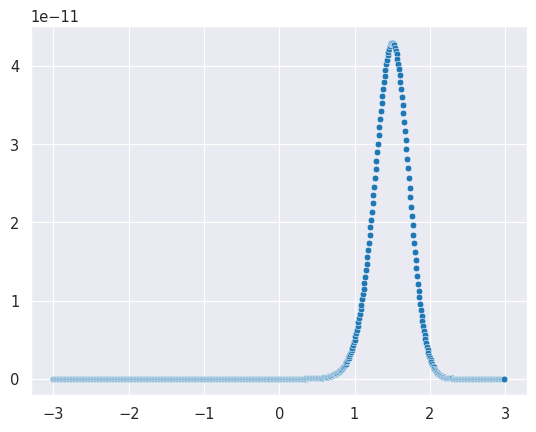

In [52]:
theta = np.arange(-3,3,0.01)
sns.scatterplot(x=theta,y=padr_prob(theta,pp))

Vemos que há um pico probabilidade em algum theta. Esta maneira de estimar a habilidade mais provável que gerou este padrão de resposta é chamado de "máxima verossimilhança". (A verossimilhança aqui é essencialmente o modelo para a probabilidade dos padrões de resposta, se considerar esta probabilidade como uma função do parâmetro theta e considerando os 45 parâmetros a, b e c como conhecidos e fixos).

Para fins didáticos, podemos mostrar como a probabilidade de acertar as questões evolui questão por questão. Na medida que mais informação entra (na forma de acertos e falhas de questões), o modelo "aprende" com cada vez mais precisão o que seria a habilidade theta associada a esta padrão de respostas.

In [53]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [54]:
padr

126039          1.0
85504           1.0
28932           0.0
125935          0.0
126028          1.0
13725           1.0
141513          1.0
27119           1.0
125902          0.0
111754          1.0
14366           1.0
125969          1.0
48324           0.0
31650           1.0
141582          1.0
117706          1.0
141570          1.0
86783           0.0
24523           0.0
81743           1.0
37441           0.0
32176           1.0
117633          1.0
125977          1.0
141540          0.0
81742           1.0
14389           0.0
14994           0.0
117634          0.0
111446          1.0
39385           0.0
125929          0.0
14410           0.0
141567          1.0
98278           1.0
81946           0.0
27330           1.0
16795           0.0
141566          1.0
125884          1.0
84857           1.0
125888          1.0
125933          0.0
acertos        28.0
caderno      1211.0
nota_inep     728.3
Name: 210060323598, dtype: float64

In [55]:
def displaypadr(s):
    def check(s):
        if s: return '✔'
        else: return '✖'
    s = s.apply(check)
    s = ''.join(list(s.values))
    if len(s) > 20:
        return s[:20] + "\n" + s[20:]
    return s

padrs = load_acertos(2023,'MT',2)
for index,padr in padrs.iterrows():
    print(index,displaypadr(padr))

210061345920 ✔✔✖✔✖✖✔✖✖✖✖✔✔✔✖✖✖✖✖✔
✖✖✖✖✖✖✔✖✖✔✖✖✖✖✔✔✖✖✖✔✖✔✖✔✔✔
210060895590 ✔✖✔✔✖✖✔✔✖✖✖✔✖✔✖✔✔✔✖✔
✖✖✖✖✖✖✔✔✖✖✔✖✖✔✖✔✖✔✖✖✖✖✔✔✔✔


In [57]:
# escolher um padrão de resposta
ano = 2023
area = 'CN'
pp,nota_inep = padrparams(ano,area,nota_inep=True,acertos=9)
print(nota_inep)

def viz_padr_prob(pp,until=None,posterior=False,returnfig=False):
    'Gráfico da verossimilhança em função de theta, dado parâmetros TRI e um padrão de resposta'
    
    fig = plt.figure()
    theta = np.arange(-4,4,0.01)
    if until:
        pp = pp[:until]
    padr = pp.iloc[:,-1]
    s = displaypadr(padr)
    lh = padr_prob(theta,pp,posterior=posterior)
    ax = sns.scatterplot(x=theta,y=lh)
    nota_ml = (-4+lh.argmax()*0.01)
    lhmax = lh[lh.argmax()]
    #print(lhmax,nota_ml)
    ax.axvline(x=nota_ml,ymin=0,ymax=1,ls='--',lw=2,c='orange')
    ax.set_title(f"Após {until} respostas ("+s+")",loc='left')
    ax.set_xlabel(r"$\theta$ (unidade de desvio padrão)")
    ax.set_ylabel(r"$P(y_i|\theta$)")
    #ax.set_yticks([])
    if returnfig:
        return fig
    
iw = widgets.BoundedIntText(
    value=2,
    min=1,
    max=45,
    step=1,
    description='Número de repostas:',
    disabled=False
)

interact(viz_padr_prob,pp=fixed(pp),until=iw,posterior=fixed(False));
#fig = viz_padr_prob(pp,1)
#fig.savefig('images/test.png',dpi=300)

              acertos  caderno  nota_inep
candidato                                
210059476021        9     1221      515.1


interactive(children=(BoundedIntText(value=2, description='Número de repostas:', max=45, min=1), Checkbox(valu…

In [58]:
# para fazer um filminho...
acertos = 40
ano = 2023
area = 'MT'
pp,nota_inep = padrparams(ano,area,nota_inep=True,acertos=acertos)
for i in range(1,46):
    fig = viz_padr_prob(pp,i,returnfig=True)
    fig.savefig(f'images/tri/{acertos}/{area}-{ano}n{i}.png',dpi=300)
    plt.close(fig)

2016 / CN | 501.1 | 113.1 | 0.005


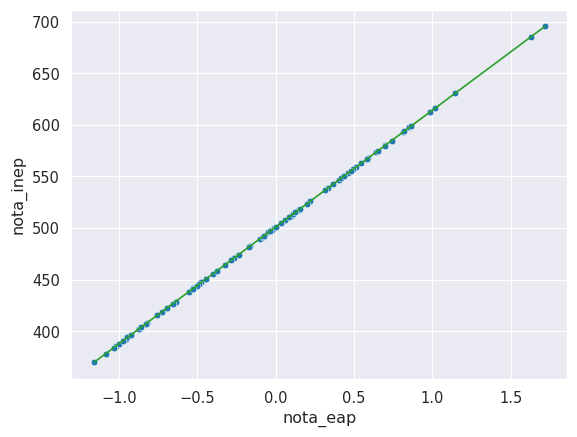

In [59]:
ano = 2016
area = 'CN'
theta = np.arange(-4,4,0.001)

d = {'acertos':[],'nota_inep':[],'nota_ml':[],'nota_eap':[]}
        
for i in range(100):
    pp,notas = padrparams(ano,area,1,nota_inep=True)
    nota, acertos = notas['nota_inep'].values[0], notas['acertos'].values[0]
    lh, posterior = padr_prob(theta,pp,posterior=True)
    nota_ml = (-4+lh.argmax()*0.001)
    nota_eap = np.average(theta, weights=posterior)
    d['acertos'].append(acertos)
    d['nota_inep'].append(nota)
    d['nota_ml'].append(nota_ml)
    d['nota_eap'].append(nota_eap)
df = pd.DataFrame(d)
res = scipy.stats.linregress(df['nota_eap'], df['nota_inep'])
sns.scatterplot(df,x='nota_eap',y='nota_inep')
sns.lineplot(x=df['nota_eap'],y=res.intercept + res.slope*df['nota_eap'],color='C2')
print(f"{ano} / {area} | {res.intercept:.1f} | {res.slope:.1f} | {res.stderr:.3f}")

In [ ]:
theta = np.arange(-4,4,0.001)

N = 100
results = pd.DataFrame(columns=['ano','area','slope','intercept','stderr','warning'])
for ano in range(2009,2024):
    for area in ['CN','CH','MT']:
        d = {'acertos':[],'nota_inep':[],'nota_ml':[],'nota_eap':[]}
        
        for i in range(N):
            pp,notas = padrparams(ano,area,1,nota_inep=True)
            nota, acertos = notas['nota_inep'].values[0], notas['acertos'].values[0]
            lh, posterior = padr_prob(theta,pp,posterior=True)
            nota_ml = (-4+lh.argmax()*0.001)
            nota_eap = np.average(theta, weights=posterior)
            d['acertos'].append(acertos)
            d['nota_inep'].append(nota)
            d['nota_ml'].append(nota_ml)
            d['nota_eap'].append(nota_eap)
        notas = pd.DataFrame(d)
        
        res = scipy.stats.linregress(notas['nota_eap'], notas['nota_inep'])
        sns.scatterplot(notas,x='nota_eap',y='nota_inep')
        sns.lineplot(x=notas['nota_eap'],y=res.intercept + res.slope*notas['nota_eap'],color='C2')
        if res.stderr < 0.05:
            warning = '✅'
        else: 
            warning = '❌'
        results.loc[len(results)] = [ano,area,res.slope,res.intercept,res.stderr,warning]
        print(f"{warning} {ano}, {area} |\t {res.intercept:.1f} |\t {res.slope:.1f} |\t {res.stderr:.3f}")
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal-python-{N}.csv',index=False)

✅ 2009, CN |	 501.1 |	 113.1 |	 0.004


In [60]:
results.sort_values('ano')

NameError: name 'results' is not defined